# Data Mining
## Ensemble Decision Tree Classifier for Income Classification

### Import Libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time

### Creating a Class to define the structure of a Node in the Tree

In [2]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.label = label
        self.children = {}

### The Decision Tree Classifier using Hunt's Algorithm

In [3]:
class DecisionTreeClassifierHunt:
    def __init__(self, maxDepth=None, minSamplesLeaf=1):
        # Initialize the decision tree classifier with given parameters.
        self.maxDepth = maxDepth  # Maximum depth of the tree.
        self.minSamplesLeaf = minSamplesLeaf  # Minimum samples in a leaf node.
        self.tree = None  # Placeholder for the decision tree structure.

    def fit(self, features, target):
        # Train the decision tree classifier on the provided data.
        self.tree = self.buildTree(features, target, depth=0)

    def buildTree(self, features, target, depth):
        # Recursively build the decision tree structure based on data and conditions.
        # Conditions include depth, purity, and minimum samples per leaf.
        if depth == self.maxDepth or len(np.unique(target)) == 1 or len(target) < self.minSamplesLeaf:
            # Stop building if max depth, purity, or sample size conditions are met.
            return TreeNode(label=np.bincount(target).argmax())

        bestFeature, bestThreshold = self.findBestSplit(features, target)
        # Find the best feature and threshold for data split.

        if bestFeature is None:
            # If no good split found, return a leaf with the majority class label.
            return TreeNode(label=np.bincount(target).argmax())

        node = TreeNode(feature=bestFeature, threshold=bestThreshold)
        # Create a new tree node with the best split information.

        leftIndices = features[:, bestFeature] <= bestThreshold
        rightIndices = ~leftIndices
        # Split data based on the selected feature and threshold.

        node.children[0] = self.buildTree(features[leftIndices], target[leftIndices], depth + 1)
        node.children[1] = self.buildTree(features[rightIndices], target[rightIndices], depth + 1)
        # Recursively build left and right subtrees.

        return node

    def findBestSplit(self, features, target):
        # Search for the best feature and threshold to minimize Gini impurity.
        bestGini = 1
        bestFeature = None
        bestThreshold = None

        for feature in range(features.shape[1]):
            thresholds = np.unique(features[:, feature])

            for i in range(1, len(thresholds)):
                threshold = (thresholds[i - 1] + thresholds[i]) / 2.0

                leftIndices = features[:, feature] <= threshold
                rightIndices = ~leftIndices

                if len(target[leftIndices]) < self.minSamplesLeaf or len(target[rightIndices]) < self.minSamplesLeaf:
                    continue

                gini = self.calculateGiniImpurity(target[leftIndices], target[rightIndices])

                if gini < bestGini:
                    bestGini = gini
                    bestFeature = feature
                    bestThreshold = threshold

        return bestFeature, bestThreshold

    def calculateGiniImpurity(self, leftLabels, rightLabels):
        # Calculate Gini impurity to evaluate data split.
        probLeft = len(leftLabels) / (len(leftLabels) + len(rightLabels))
        probRight = 1 - probLeft

        giniLeft = 1 - sum((np.sum(leftLabels == label) / len(leftLabels)) ** 2 for label in np.unique(leftLabels))
        giniRight = 1 - sum((np.sum(rightLabels == label) / len(rightLabels)) ** 2 for label in np.unique(rightLabels))

        giniImpurity = probLeft * giniLeft + probRight * giniRight
        return giniImpurity

    def predict(self, features):
        # Make predictions for a list of feature vectors.
        return np.array([self.predictTree(x, self.tree) for x in features])

    def predictTree(self, x, node):
        # Recursively traverse the decision tree to predict a class label for a single input.
        if node.label is not None:
            return node.label

        if x[node.feature] <= node.threshold:
            return self.predictTree(x, node.children[0])
        else:
            return self.predictTree(x, node.children[1])


### Importing the Training Data (adult.data)

In [4]:
# Load the dataset
df = pd.read_csv(r'Census Income Data Set/adult.data', header=None, na_values=[' ?'])

# Define column names
columnNames = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation',
               'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Assign column names
df.columns = columnNames

df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


### Data Overview

In [5]:
print ("Rows     : " ,df.shape[0])
print ("Columns  : " ,df.shape[1])
print ("\nFeatures : \n" ,df.columns.tolist())
print ("\nMissing values :  ", df.isnull().sum().values.sum())
print ("\nUnique values :  \n",df.nunique())

Rows     :  32561
Columns  :  15

Features : 
 ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

Missing values :   4262

Unique values :  
 age                  73
workclass             8
fnlwgt            21648
education            16
education-num        16
marital-status        7
occupation           14
relationship          6
race                  5
sex                   2
capital-gain        119
capital-loss         92
hours-per-week       94
native-country       41
income                2
dtype: int64


In [6]:
df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
percent_missing = (df.isnull()).sum() * 100/len(df)
percent_missing

age               0.000000
workclass         5.638647
fnlwgt            0.000000
education         0.000000
education-num     0.000000
marital-status    0.000000
occupation        5.660146
relationship      0.000000
race              0.000000
sex               0.000000
capital-gain      0.000000
capital-loss      0.000000
hours-per-week    0.000000
native-country    1.790486
income            0.000000
dtype: float64

In [8]:
df.isna().any(axis=1).sum()

2399

### Preprocess the Training Dataset (adult.data)

#### Drop missing values

In [9]:
df.dropna(inplace=True)

In [10]:
# Convert 'income' column to binary labels (0 for <=50K, 1 for >50K)
print(df['income'].value_counts())
df['income'] = df['income'].apply(lambda x: 0 if x == ' <=50K' else 1)
print(df['income'].value_counts())


 <=50K    22654
 >50K      7508
Name: income, dtype: int64
0    22654
1     7508
Name: income, dtype: int64


#### Separate features and target variable

In [11]:
features = df.drop('income', axis=1)
target = df['income']
print(target.value_counts())

0    22654
1     7508
Name: income, dtype: int64


#### Encode categorical features

In [12]:
label_encoders = {} #label_encoders is saved to be used while preprocessing test data
for column in features.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    features[column] = le.fit_transform(features[column])
    label_encoders[column] = le


### Train the Ensemble Model of 10 Decision Tree Clasifiers

In [13]:
#features.drop(columns=columns_to_remove)

numBaseModels = 10

baseModels = []

samples_per_class = 2000
class_0_indices = target[target == 0].index
class_1_indices = target[target == 1].index

# Train individual base models
finalTrainingTime = 0
for i in range(numBaseModels):       
    # Create a new instance of DecisionTreeClassifierHunt with custom parameters
    baseModel = DecisionTreeClassifierHunt(maxDepth=10, minSamplesLeaf=5)

    
    # Randomly select a subset of the training data having equal count of each class for each base model
    sampled_class_0_indices = np.random.choice(class_0_indices, size=samples_per_class, replace=False)
    sampled_class_1_indices = np.random.choice(class_1_indices, size=samples_per_class, replace=False)
    
    
    # Combine the indices of both classes
    sampledIndices = np.concatenate([sampled_class_0_indices, sampled_class_1_indices])
    sampleIndices = np.random.choice(len(sampledIndices), size=int(0.7 * len(sampledIndices)), replace=False)
    sampledFeatures = features.iloc[sampleIndices]
    sampledTarget = target.iloc[sampleIndices]
    
    start_time = time.time()
    
    # Train the base model on the sampled data
    baseModel.fit(sampledFeatures.to_numpy(), sampledTarget.to_numpy())
    
    training_time = time.time() - start_time
    finalTrainingTime += training_time
    
    # Append the trained base model to the list
    baseModels.append(baseModel)
    print("Model ",i+1, " training completed. Training time:", training_time, "seconds")
    
print("\n\n The Total training time for the model is ", finalTrainingTime)


Model  1  training completed. Training time: 3.2542431354522705 seconds
Model  2  training completed. Training time: 3.1622488498687744 seconds
Model  3  training completed. Training time: 2.848464012145996 seconds
Model  4  training completed. Training time: 2.95104718208313 seconds
Model  5  training completed. Training time: 2.9663941860198975 seconds
Model  6  training completed. Training time: 3.029052257537842 seconds
Model  7  training completed. Training time: 3.0786495208740234 seconds
Model  8  training completed. Training time: 2.8270511627197266 seconds
Model  9  training completed. Training time: 2.6952407360076904 seconds
Model  10  training completed. Training time: 2.9935622215270996 seconds


 The Total training time for the model is  29.80595326423645


### Import and Preprocess the Test Data (adult.test)

In [14]:
testDf = pd.read_csv(r'Census Income Data Set/adult.test',skiprows=1, header=None, na_values=[' ?'])

# Assign column names
testDf.columns = columnNames
testDf.dropna(inplace=True)

# Convert 'income' column to binary labels (0 for <=50K, 1 for >50K)
testDf['income'] = testDf['income'].apply(lambda x: 0 if x == ' <=50K.' else 1)
print(testDf.income.unique())

# Separate features and target variable
testFeatures = testDf.drop('income', axis=1)
actualClass = testDf['income']

#Use the same encoder used during Training
for column, le in label_encoders.items():
    testFeatures[column] = le.transform(testFeatures[column])
        
testFeatures.head()

[0 1]


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25,2,226802,1,7,4,6,3,2,1,0,0,40,38
1,38,2,89814,11,9,2,4,0,4,1,0,0,50,38
2,28,1,336951,7,12,2,10,0,4,1,0,0,40,38
3,44,2,160323,15,10,2,6,0,2,1,7688,0,40,38
5,34,2,198693,0,6,4,7,1,4,1,0,0,30,38


### Apply the Model on Test Dataset (adult.test)

In [15]:
# Use the ensemble of base models to make predictions on test data
# Replace test_features with your test data

predictionList = []
accuracyall =[]
i=1
for model in baseModels:
    modelPredictions = model.predict(testFeatures.to_numpy())
    predictionList.append(modelPredictions)
    accuracy = (np.mean(modelPredictions == actualClass))
    accuracyall.append(accuracy)
    print("Accuracy of model ",i,' ',accuracy)
    i+=1

# Combine predictions using majority voting for classification
combinedPredictions = np.array(predictionList).T  # Transpose for element-wise voting
predictions = np.array([np.bincount(pred).argmax() for pred in combinedPredictions])

# Evaluate the ensemble model's performance (e.g., using accuracy)
# Compare ensemble_predictions with actualClass
accuracy = np.mean(predictions == actualClass)

print("Accuracy of the Final Model:", accuracy)
print()

Accuracy of model  1   0.8203851261620186
Accuracy of model  2   0.8150730411686588
Accuracy of model  3   0.8244355909694555
Accuracy of model  4   0.8263612217795485
Accuracy of model  5   0.8187250996015937
Accuracy of model  6   0.8231739707835325
Accuracy of model  7   0.8251660026560425
Accuracy of model  8   0.8225099601593625
Accuracy of model  9   0.8179282868525897
Accuracy of model  10   0.8114873837981408
Accuracy of the Final Model: 0.8372509960159362



### Confusion Matrix Calculation

[[10403   957]
 [ 1494  2206]]


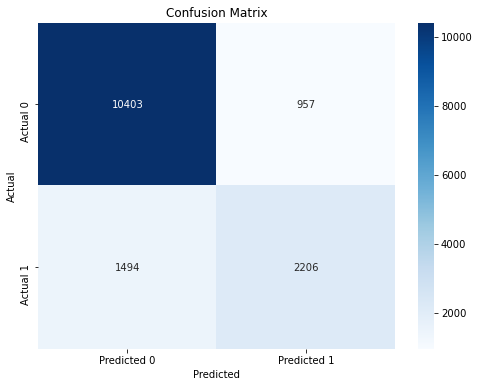

In [18]:
# Compute the confusion matrix
conf_matrix = confusion_matrix(actualClass, predictions)
print(conf_matrix)
# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'], 
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

### Performance Metrics

In [17]:
# Assuming actualClass contains the true labels and predictions contains the predicted labels
cm = confusion_matrix(actualClass, predictions)

# Extract values from the confusion matrix
TN, FP, FN, TP = cm.ravel()

# Calculate classification metrics
accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * (precision * recall) / (precision + recall)

# Print the computed metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)


Accuracy: 0.8372509960159362
Precision: 0.697439140056908
Recall: 0.5962162162162162
F1-Score: 0.6428675506338336
